# Final Exam (Linear Programming and Approximation Algorithms)

This is a take home final exam. You have __30 hours__ to tackle three problems where you will be expected to come up with algorithms for solving two problems, coding up the solution and passing the test cases. 

  - The time limit is strict: submissions or modifications of earlier submissions after the time limit has elapsed will not be accepted and receive no points.

This exam is open book and notes. You are allowed to consult any course material presented in this class. However, seeking external help (searching the internet, asking others or asking a generative AI system) for solving the problems online is _strictly forbidden_. You may however consult online documentation on the python language or the pulp LP solver.

To be clear: 
  - It is OK to consult online resources on python programming. Eg., you forgot how to implement a class in Python or you need to consult the documentation for PuLP, then it is OK to search online.
     - Using generative AI for basic programming help is fine thought not encouraged for an exam.
  - It is forbidden to ask for any kind of online help for solving the algorithmic problems.
     - Using generative AI for help with solving the problem is forbidden.
     - Posting these problems on online forums is forbidden.
     - Searching online for solutions is forbidden.
     - Asking a classmate or friend for help is forbidden.
 
 

## Problem 1 (25 points)

A logistics company ships natural gas over trains between different places. The places form the vertices of an undirected graph and each (bi-directional) edge between two vertices denotes a rail line over which fuel can be transported by train in either direction.  We associate with each edge a cost/unit that specifies how much it costs to send one unit of oil between the two end points (in either direction). Some of the vertices are oil producing vertices where there is a net supply of oil whereas the other vertices are demand vertices where there is a net demand for oil. We will write demand as negative supply.

### Example

Here is an example involving five cities: $\{ Houston, Chicago, Baltimore, Philadelphia, Charleston \}$ and the edges are shown below along with shipping cost per unit along each edge (in red).

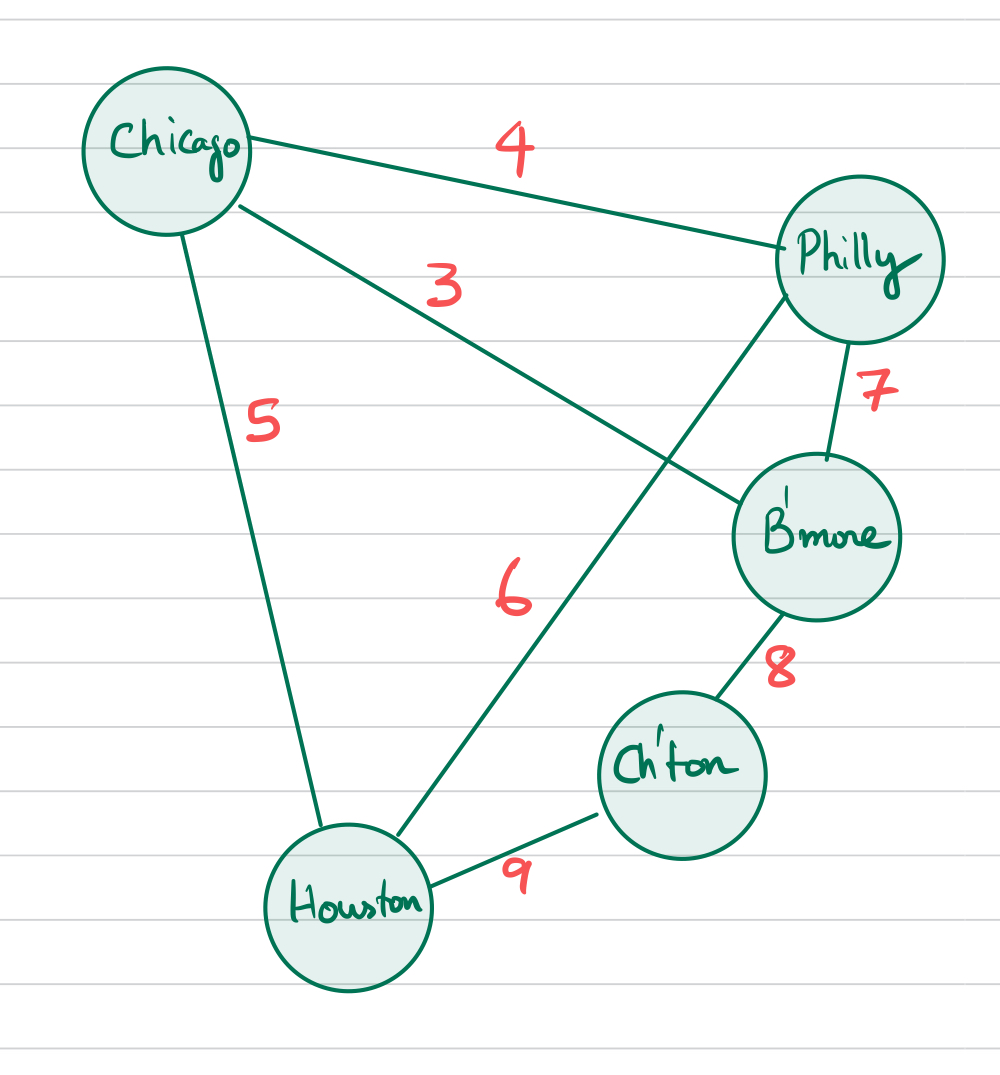</img>

The following table summarizes the net supply (or demand) in metric tonnes for each city.

$$\begin{array}{l l}
\hline
\text{City} & \text{Net Supply} \\ 
\hline 
Houston & 100 \\ 
Chicago & -55 \\ 
Baltimore & 35 \\ 
Philadelphia & -40 \\ 
Charleston & - 25 \\ 
\hline
\end{array}$$

Notice that in Houston and Baltimore, there is a net supply whereas Chicago, Philadelphia and Charleston have net demands (negative supplies). 

We wish to find out how much oil to transport along each of the rail lines (edges of the graph)  so that the following constraints are met and the total transportation cost is minimized.

  - For each city with a net oil demand, the total inflow of oil into the city minus the total outflow of oil from the city must be equal to the total demand of the city.
  - For each city with a net oil supply, the total outflow of oil from the city minus the total inflow into the city must be _less than or equal_ to the net supply available for the city. 
  



For instance, consider the following shipping schedule:


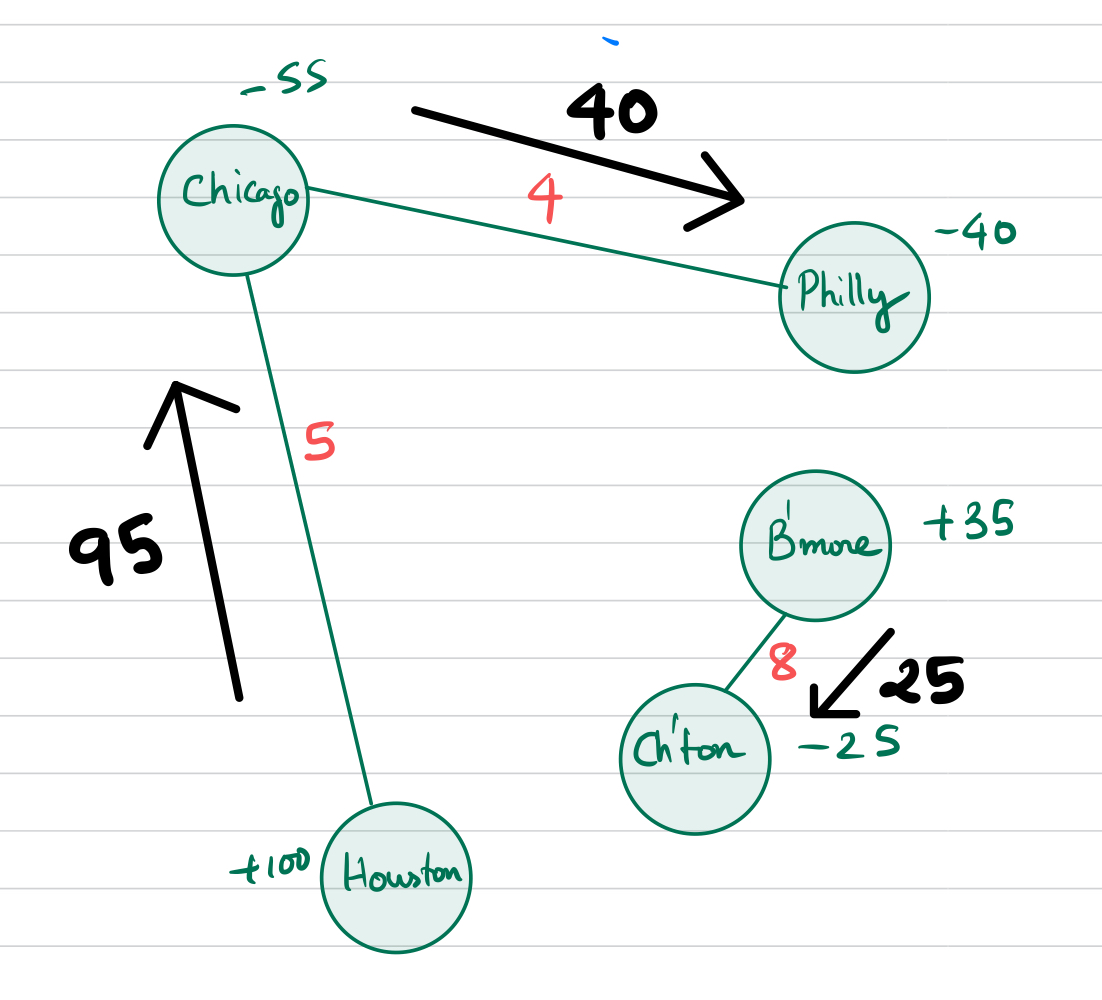 </img>

We ship $95$ units of oil from Houston to Chicago, $40$ units from Chicago to Philly, and $25$ units of oil from Baltimore to Charleston. 

Does it satisfy all constraints?
  - At Houston there is a net supply of $100$. The total outflow is $95$ and total inflow is $0$. We have $95 \leq 100$.
  - At Chicago, there is a net demand of $55$. Total inflow is $95$ and total outflow is $40$. Thus $95 - 40 = 55$.
  - Similarly, verify that the constraints are satisfied at all the other cities.
  
The total transportation cost is $ 95 * 5 + 40 * 4 + 25 * 8 = 835$. Can we do better than this in terms of cost?

Formulate a linear programming problem to solve the transportation problem. You are given as input: 
  - Graph with vertices $V$ and edges $E$. Each _undirected_ edge $(i,j)$ can be regarded as two edges $(i,j)$ and $(j,i)$ in opposite directions, if it is easier for your solution. 
  - A cost $c: E \mapsto \mathbb{R}$ associated with each edge such that $c(e) \geq 0$ and is the cost of transporting one unit of oil along the edge.
  - A map $s: V \mapsto \mathbb{R}$ mapping each vertex $v$ to net supply $s(v)$. (note that if $s(v) \leq 0$ then it is considered a demand).
  

We suggest following steps on pencil/paper to formulate the problem.
  - (a) identify all the decision variables,
  - (b) write down the constraints, and
  - (c) write down the objective function.
  
Complete the python function `calculateOptimalPlan` that takes inputs:
  - `n`: number of vertices which are numbered $0, \ldots, n-1$;
  - `edge_list`: a list of undirected edges $(i,j,c)$ between vertices wherein $c \geq 0$ is the cost of flow along the edge; 
  - `supplies`: a list of size $n$ where `supplies[j]` is the supply (or demand if negative) at the jth vertex.
  
Your function must return a dictionary that maps edges `(i,j)` to the flow along the edge in the direction $i \rightarrow j$.
  - All flows  must be non-negative.
  - If you specify a flow from $j$ to $i$, then your dictionary must have the key `(j,i)` mapped to the non-negative flow from $j$ to $i$.
  - If an edge is not present in the dictionary, we will take the flow along it to be zero.

In [8]:
from pulp import *
def calculateOptimalPlan(n, edge_list, supplies, debug=False):
    assert n >= 1
    assert all( 0 <= i < n and 0 <= j < n and i != j and c >= 0 for (i,j,c) in edge_list)
    assert len(supplies) == n
    # TODO: Formulate the LP for optimal transportation plan and return the solution as a dictionary
    #       from edges (i,j) to flow from i to j.
    #       If an edge is not present in the dictionary, we will take its flow to be zero.
    # your code here
    
    directed_edges = []
    cost = {}
    adj = {v: set() for v in range(n)}
    for (u, v, c) in edge_list:

        directed_edges.append((u, v))
        cost[(u, v)] = c
        adj[u].add(v)

        directed_edges.append((v, u))
        cost[(v, u)] = c
        adj[v].add(u)

    prob = LpProblem("MinCostTransportation", LpMinimize)

    flow = {
        (i, j): LpVariable(f"f_{i}_{j}", lowBound=0, cat="Continuous")
        for (i, j) in directed_edges
    }

    prob += lpSum(cost[(i, j)] * flow[(i, j)] for (i, j) in directed_edges)

    for v in range(n):
        inflow = lpSum(flow[(u, v)] for u in adj[v]) if adj[v] else 0
        outflow = lpSum(flow[(v, u)] for u in adj[v]) if adj[v] else 0

        s = supplies[v]
        if s < 0:

            prob += inflow - outflow == (-s), f"demand_balance_{v}"
        else:

            prob += outflow - inflow <= s, f"supply_cap_{v}"

    solver = PULP_CBC_CMD(msg=1 if debug else 0)
    prob.solve(solver)

    res = {}
    for (i, j) in directed_edges:
        val = value(flow[(i, j)])
        if val is None:
            val = 0.0

        if val > 1e-9:
            res[(i, j)] = float(val)

    return res

#     raise NotImplementedError

In [9]:
def test_solution(n, edge_list, supplies, solution_map, expected_cost):
    cost = 0
    outflows = [0]*n
    inflows = [0]*n
    for (i,j,c) in edge_list:
        if (i,j) in solution_map: 
            flow = solution_map[(i,j)]
            cost += c * flow
            assert flow >= 0, f'flow on edge {(i,j)} is negative --> {flow}'
            outflows[i] += flow 
            inflows[j] += flow
        elif (j,i) in solution_map:
            flow = solution_map[(j,i)]
            cost += c * flow
            assert flow >= 0, f'flow on edge {(j,i)} in negative --> {flow}'
            outflows[j] += flow
            inflows[i] += flow 
    for (i, s) in enumerate(supplies):
        if s > 0:
            assert outflows[i]  - inflows[i] <= s, f'Vertex {i} constraint violated: total outflow = {outflows[i]} inflow = {inflows[i]}, supply = {s}'
        else:
            assert abs(inflows[i]-outflows[i] + s) <= 1E-2,f'Vertex{i} constraint violated: inflow = {inflows[i]} outflow={outflows[i]}, demand = {-s}'
    if expected_cost != None:
        assert abs(expected_cost - cost) <= 1E-02, f'Expected cost: {expected_cost}, your algorithm returned: {cost}'
    print('Test Passed!')

n = 5
edge_list = [
    (0,1, 5), (0, 3, 3), (0, 4, 4),
    (1,2, 9), (1,4, 6),
    (2,3,8),
    (3,4,7)
]
supplies = [-55, 100, -25, 35, -40]
sol_map = calculateOptimalPlan(n, edge_list, supplies, debug=True)
test_solution(n, edge_list, supplies, sol_map,670)


print('5 points!')

Test Passed!
5 points!


In [10]:
n = 10
edge_list = [
    (0, 1, 5),
    (0, 2, 4),
    (0, 3, 7),
    (0, 4, 3),
    (0, 5, 9),
    (0, 8, 6),
    (0, 9, 5),
    (1, 2, 3),
    (2, 4, 9),
    (2, 7, 8),
    (2, 8, 7),
    (2, 6, 5),
    (3, 4, 6),
    (3, 5, 7),
    (3, 6, 4),
    (3, 7, 8),
    (3, 8, 3),
    (3, 9, 5),
    (4, 8, 5),
    (5, 7, 8),
    (6, 8, 2),
    (7, 8, 3),
    (7, 9, 6),
    (8, 9, 10)
]
supplies=[
    20,
    30,
    -30,
    -40,
    10,
    15,
    20,
    -35,
    40,
    -30
]

sol_map = calculateOptimalPlan(n, edge_list, supplies, debug=True)
test_solution(n, edge_list, supplies, sol_map,575)
print('5 points')

Test Passed!
5 points


In [11]:
from random import randint,seed
def gen_random_test(n, num_edges):
    assert n >= 1
    edge_list = [(i,i+1, randint(2,10)) for i in range(n-1)]
    
    while len(edge_list) < num_edges:
        i = randint(0, n-1)
        j = randint(0, n-1)
        (i,j) = (min(i,j), max(i,j))
        if i == j: 
            continue 
        if any( ihat == i and jhat == j for (ihat, jhat, _) in edge_list):
            continue
        c = randint(2, 10)
        edge_list.append((i,j,c))
    tot = 0
    supplies=[]
    for i in range(n-1):
        si = randint(-100, 100) 
        supplies.append(si)
        tot = tot + si

    if tot <= 0:
        supplies.append(-tot)
    else:
        supplies.append(randint(1-tot, 0))
    
    return (n, edge_list, supplies)

seed(10001)
(n, edge_list,supplies) = gen_random_test(50, 100)
print(edge_list)
sol_map = calculateOptimalPlan(n, edge_list, supplies, debug=True)
test_solution(n, edge_list, supplies, sol_map,None)

(n, edge_list,supplies) = gen_random_test(45, 50)
print(edge_list)
sol_map = calculateOptimalPlan(n, edge_list, supplies, debug=True)
test_solution(n, edge_list, supplies, sol_map,None)


(n, edge_list,supplies) = gen_random_test(15,80)
print(edge_list)
sol_map = calculateOptimalPlan(n, edge_list, supplies, debug=True)
test_solution(n, edge_list, supplies, sol_map,None)

print('15 points!')

[(0, 1, 7), (1, 2, 3), (2, 3, 3), (3, 4, 8), (4, 5, 8), (5, 6, 3), (6, 7, 10), (7, 8, 6), (8, 9, 4), (9, 10, 3), (10, 11, 6), (11, 12, 2), (12, 13, 9), (13, 14, 6), (14, 15, 4), (15, 16, 5), (16, 17, 7), (17, 18, 6), (18, 19, 8), (19, 20, 9), (20, 21, 7), (21, 22, 9), (22, 23, 6), (23, 24, 8), (24, 25, 2), (25, 26, 9), (26, 27, 3), (27, 28, 10), (28, 29, 8), (29, 30, 7), (30, 31, 3), (31, 32, 7), (32, 33, 2), (33, 34, 3), (34, 35, 5), (35, 36, 7), (36, 37, 3), (37, 38, 2), (38, 39, 9), (39, 40, 7), (40, 41, 6), (41, 42, 2), (42, 43, 10), (43, 44, 4), (44, 45, 9), (45, 46, 7), (46, 47, 5), (47, 48, 9), (48, 49, 3), (42, 45, 9), (23, 48, 2), (3, 31, 8), (21, 24, 3), (13, 37, 4), (14, 30, 8), (28, 48, 8), (7, 41, 3), (20, 22, 7), (7, 23, 2), (7, 18, 6), (15, 36, 4), (18, 21, 2), (45, 48, 6), (15, 20, 9), (11, 38, 2), (15, 33, 8), (22, 32, 7), (8, 42, 6), (3, 19, 10), (20, 29, 9), (9, 30, 7), (6, 46, 3), (2, 20, 5), (8, 31, 8), (40, 46, 8), (4, 22, 3), (23, 38, 3), (7, 49, 8), (16, 28, 2),

### Problem 2 : 40 points

In this problem, you are given a set of inequality constraints $I_1, \ldots, I_m$, involving variables $(x_1, \ldots, x_n)$. 

For example, consider six inequalities shown below involving $(x_1, x_2)$:

$$ \begin{array}{rll}
 x_1 - x_2 & \leq -5 & \leftarrow I_1 \\ 
 x_1 + 2 x_2 & \leq 3 & \leftarrow I_2 \\ 
 x_1 & \geq 4  & \leftarrow I_3\\ 
 x_1 & \leq -2  & \leftarrow I_4\\ 
 x_2 & \geq 3  & \leftarrow I_5\\ 
 x_2 & \leq -1  & \leftarrow I_6\\ 
 \end{array}$$
 
 
 Further, we give you a possible range of values for each variable: $x_i \in [\ell_i, u_i]$ for limits $\ell_i, u_i$ and $i = 1, \ldots, n$.
 
In our example:  $x_1 \in [-10, 10], x_2 \in [-10, 10]$.
 
 Your goal is to find values for $(x_1, \ldots, x_n)$ wherein each $x_i$ lies within its bounds $[\ell_i, u_i]$ and at the same time satisfies as many of the inequalities above as possible.
 
For instance if we set $x_1 = -2, x_2 = -1$ in the example above, we satisfy $3$ out of the six inequalities:

$$ \begin{array}{rl}
\text{inequality} & \text{satisfied} \\ 
\hline
 x_1 - x_2  \leq -5 & \text{N}\\ 
 x_1 + 2 x_2  \leq 3 & \text{Y} \\ 
 x_1 \geq 4  &\text{N}\\ 
 x_1  \leq -2 & \text{Y} \\ 
 x_2  \geq 3 & \text{N} \\ 
 x_2  \leq -1 & \text{Y}\\ 
 \end{array}$$
 
 Can we satisfy more than $3$ inequalities by choosing some values $(x_1, x_2)$ in the range?
 
 **Inputs:** $n$ variables and $m$ inequalities.
 - Each inequality $I_j$ is of the form:
 $$I_j:  c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j \,.$$
 - Ranges $[\ell_i, u_i]$ for variable $x_i$ where $\ell_i \leq u_i$.
Note that the variables $x_1, \ldots, x_n$ can take on real-values in the range.

**Output** A point $(x_1, \ldots, x_n)$ wherein each $x_i \in [\ell_i, u_i]$ and the number of satisfied inequalities is maximized.
 
 ## (A) (Mixed) Integer Linear Programming Formulation (20 points)
 
 We will guide you through a mixed integer programming formulation for the problem.  
 - For each each inequality $I_j$ given to us, a binary decision variable $w_j \in \{0, 1\}$ which is 1 if the inequality is to be satisfied and  0 otherwise.

(i) Write down the objective in terms of $w_1, \ldots, w_m$. Write your answer in the space below. It is not graded and we provide selected answers at the end as hints.


YOUR ANSWER HERE

(ii) Consider the inequality  $$I_j:  c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j \,.$$

Given that each $x_i \in [\ell_i, u_i]$ are the bounds for each variable $x_i$,  let $\mathsf{upperBoundLHS}(I_j)$ denote the maximum value that the LHS Expression $c_{j1} x_1 + \cdots + c_{jn} x_n$ takes in the
domain $x_1 \in [\ell_1, u_1], \ldots, x_n \in [\ell_n, u_n]$.

As an example, suppose $x_1 \in [-1, 1]$ and $x_2 \in [-3, 2]$ then an upper bound on the expression $2 x_1 - 4 x_2$ is given by $ 2 \times 1 - 4 \times (-3) = 14$.

Write an expression for $\mathsf{upperBoundLHS}(c_1 x_1 + \cdots + c_n x_n \leq d)$ as a function of 
$c_1, \ldots, c_n, d, \ell_1, u_1, \ldots, \ell_n, u_n$.


YOUR ANSWER HERE

(iii) We are now ready for encoding the problem of maximizing the number of satisfied inequalities as an mixed integer linear programming involving decision variables  $x_1, \ldots, x_n \in \mathbb{R}$ and $w_1, \ldots, w_m \in \{0, 1\}$.

For each inequality $I_j: c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j$, we convert it into the following 
inequality
$$ \hat{I}_j:\ c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j w_j + M_j (1 - w_j) $$
where $M_j = \mathsf{upperBoundLHS}(I_j)$.

Prove that $\hat{I}_j$ is the same as $I_j$ when $w_j = 1$ and $\hat{I}_j$ is implied by the other constraints 
when $w_j = 0$. Write down the argument below (not graded).


YOUR ANSWER HERE

Complete the formulation of the optimizaition problem and implement the function `solveForMaximumInequalitySatisfaction` with the following arguments
  - `n` the number of variables
  - `m` the number of inequalities
  - `c_matrix`: a list of list of coefficients  of the LHS of inequalities
  $$ \left[ \begin{array}{c}
  [ c_{11}, \ldots, c_{1n}], \\ 
  [ c_{21}, \ldots, c_{2n}], \\  
  \cdots \\
  [ c_{m1}, \ldots, c_{mn}] \\
  \end{array}\right]$$
  Please note python indexes starting from 0.
 - `d_values`: a list of RHS coefficients: $[ d_1, \ldots, d_m ] $
 - `bounds: `: a list of pairs $[(\ell_1, u_1), \ldots, (\ell_n, u_n)]$ for each variable.
 
 Your function should return a pair:  $(k, [x_1, \ldots, x_n ] )$
   - The number of inequalities satisfied by your optimal solution ($k$)
   - A list denoting the values of $x_1, \ldots, x_n$ that satisfy the $k$ inequalities.
   
Please use the pulp solver.

In [12]:
from pulp import *

# Here is a useful function to implement the LHS upper bound that we need for the encoding
def lhsUpperBound(c_list, bounds):
    n = len(c_list)
    assert len(bounds) == n 
    upper_bnd = sum([(cj*lj) if cj < 0 else cj*uj for (cj, (lj, uj)) in zip(c_list, bounds) ])
    return upper_bnd

def solveForMaximumInequalitySatisfaction(n, m, c_matrix, d_values, bounds):
    # always check pre-conditions: saves so much time later
    assert len(c_matrix) == m
    assert all(len(c_list) == n for c_list in c_matrix)
    assert len(d_values) == m
    assert len(bounds) == n
    assert all (lj <= uj for (lj, uj) in bounds)
    ## TODO: set up and solve the problem for satisfying the maximum number of inequalities
    # your code here
#     raise NotImplementedError

    x = [LpVariable(f"x_{i}", lowBound=bounds[i][0], upBound=bounds[i][1], cat="Continuous") for i in range(n)]
    w = [LpVariable(f"w_{j}", lowBound=0, upBound=1, cat="Binary") for j in range(m)]
    
    prob = LpProblem("MaxInequalitySatisfaction", LpMaximize)
    prob += lpSum(w), "maximize_satisfied_inequalities"
    
    for j in range(m):
        Mj = lhsUpperBound(c_matrix[j], bounds)
        lhs = lpSum(c_matrix[j][i] * x[i] for i in range(n))
        prob += lhs <= d_values[j] * w[j] + Mj * (1 - w[j]), f"ineq_{j}"
        
    prob.solve(PULP_CBC_CMD(msg=0))
    
    k = int(round(sum(value(wj) if value(wj) is not None else 0 for wj in w)))
    x_vals = [float(value(xi)) if value(xi) is not None else None for xi in x]
    
    return (k, x_vals)
        
    

In [13]:
def testSolution(n, m, c_matrix, d_values, bounds, x_values, k_expected):
    # always check pre-conditions: saves so much time later
    assert len(c_matrix) == m
    assert all(len(c_list) == n for c_list in c_matrix)
    assert len(d_values) == m
    assert len(bounds) == n
    assert all (lj <= uj for (lj, uj) in bounds)
    assert len(x_values) == n
    assert 0 <= k_expected <= m
    # check solution within bounds
    for i in range(n):
        (lb, ub) = bounds[i]
        assert lb <= x_values[i] <= ub, f'x_{i} fails to be within its bounds {[lb, ub]}'
    # Check how many inequalities satisfied
    num_ineqs = 0
    
    for (c_list, d) in zip(c_matrix, d_values):
        if sum([cj * xj for (cj, xj) in zip(c_list,x_values )]) <= d+1E-3:
            num_ineqs = num_ineqs + 1
    assert num_ineqs == k_expected, f' Expected number of inequalities to be sat: {k_expected} your solution satisfies: {num_ineqs} inequalities '
    print('Test Passed')
    return 
        
        
        
        

# x_1 - x_2 & \leq -5 & \leftarrow I_1 \\ 
# x_1 + 2 x_2 & \leq 3 & \leftarrow I_2 \\ 
# x_1 & \geq 4  & \leftarrow I_3\\ 
# x_1 & \leq -2  & \leftarrow I_4\\ 
# x_2 & \geq 3  & \leftarrow I_5\\ 
# x_2 & \leq -1  & \leftarrow I_6\\ 

n = 2
m = 6
c_matrix = [
    [1, -1],  # I_1: x_1 - x_2 <= -5
    [1, 2],   # I_2: x_1 + 2x_2 <= 3
    [-1, 0],  # I_3: -x_1 <= -4 --> x_1 >= 4
    [1, 0],   # I_4: x_1 <= -2
    [0, -1],  # I_5: -x_2 <= -3 --> x_2 >= 3
    [0, 1]    # I_6: x_2 <= -1
]

d_list = [
    -5, 3, -4, -2, -3, -1
]

bounds = [(-10, 10), (-10, 10)]

(k, x_values) = solveForMaximumInequalitySatisfaction(n, m, c_matrix, d_list, bounds)
testSolution(n, m, c_matrix, d_list, bounds, x_values, 4)
print('5 points')

Test Passed
5 points


In [14]:

n = 3
m = 12
c_matrix = [
    [1, -1, 0],
    [1, 2, 0],
    [-1, 0, 1],
    [1, 0, 0],
    [-1, 0, 0],
    [1, 0, 0],
    [1, 0, -1],
    [0, 2, 1],
    [-1, 1, 1],
    [1, 1, 1],
    [-1, 1, 1],
    [1, 1, 1],
]

d_list = [
    -5, 3, -4, -2, -3, -1,
    -5, 3, -4, -2, -3, -1
]

bounds = [(-10, 10), (-10, 10), (-12, 12)]

(k, x_values) = solveForMaximumInequalitySatisfaction(n, m, c_matrix, d_list, bounds)
testSolution(n, m, c_matrix, d_list, bounds, x_values, 10)
print('7 points')

Test Passed
7 points


In [15]:
n = 5
m = 24
c_matrix = [
    [1, -1, 0, 1, -1],
    [1, 2, 0, 0, 2],
    [-1, 0, 1, 1, 1],
    [1, 0, 0, 0, -1],
    [-1, 0, 0, -1, -1],
    [1, 0, 0, 1, 1],
    [1, 0, -1, 1, 0],
    [0, 2, 1, 0, 2],
    [-1, 1, 1, -1, 0],
    [1, 1, 1, 0, 1],
    [-1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0],
    [-1, 1, 0, 1, -1],
    [1, -2, 0, 0, -2],
    [1, 0, 1, -1, -1],
    [1, 0, 1, 0, 1],
    [-1, 0, 0, 1, 1],
    [-1, 0, 0, 1, 1],
    [1, -1, 1, 1, 1],
    [0, -2, -1, 0, 2],
    [-1, -1, -1, -1, 0],
    [-1, 1, -1, 0, 1],
    [1, 0, 0, 1, 0],
    [-1, 0, -1, 0, -1],
]

d_list = [
    -5, 3, -4, -2, -3, -1,
    -5, 3, -4, -2, -3, -1,
     5, -3, 4, 2, 3, 1,
    5, -3, 4, 2, 3, 1,
    
]

bounds = [(-10, 10), (-10, 10), (-12, 12), (-1, 3), (3, 6)]

(k, x_values) = solveForMaximumInequalitySatisfaction(n, m, c_matrix, d_list, bounds)
testSolution(n, m, c_matrix, d_list, bounds, x_values, 18)
print('8 points')

Test Passed
8 points


## Part (B) Design a Factor-2 Approximation Algorithm (20 points)


We will design a factor-2 approximation algorithm. To do so, first consider the case when there is just one variable in our problem.

#### Example

$$ \begin{array}{l}
x & \leq 5 \\ 
-x & \leq -4 \\ 
x & \leq 3 \\ 
x & \leq 15 \\ 
-x & \leq -6 \\ 
-x & \leq -8  \\
-x & \leq -3\\
\end{array}$$


Let us consider $m$ inequalities involving just one variable $x$. 

For convenience, we will drop  the upper/lower bounds. In other words, the bounds are simply 
$$x \in (-\infty, \infty)\,.$$


(i) Design an algorithm that discovers a value of $x$ guaranteed to satisfy $\lceil \frac{m}{2} \rceil$ or more inequalities. 

**Hint** Try satisfying all the inequalities of the form $x \leq d_j$ at once or alternatively, try satisfying all inequalities of the form $ - x \leq d_j$  at once. 



Write down your approach below (not graded).


YOUR ANSWER HERE

Using the algorithm for $n = 1$ variables, implement an algorithm that achieves a factor-2 approximation for inequalities with arbitrary $n$.

Specifically, given a system of $m$ inequalities over $x_1, \ldots, x_n$, provide an algorithm that finds a solution $(x_1, \ldots, x_n)$ that satisfies $\geq \frac{m}{2}$ inequalities. 

Once again, we drop the upper/lower bounds on the variables. I.e, $x_i \in (-\infty, \infty)$.

**Hint** Generate $n$ random numbers $r_1, \ldots, r_n$ in some range $[-1,1]$ and simply substitute: 
$$ x_1 = r_1 x, x_2 = r_2 x, \ldots, x_n  = r_n x$$
where  $x$ is a new unknown variable. 
Use this trick to reduce the constraints involving $n$ variables to a single variable $x$; and apply previous result. 

Implement a function `computeApproximateSolution` with inputs
 - `n`: number of variables.
 - `m`: number of inequalities
 - `c_matrix`: a list of list of coefficients  of the LHS of inequalities
  $$ \left[ \begin{array}{c}
  [ c_{11}, \ldots, c_{1n}], \\ 
  [ c_{21}, \ldots, c_{2n}], \\  
  \cdots \\
  [ c_{m1}, \ldots, c_{mn}] \\
  \end{array}\right]$$
  Please note python indexes starting from 0.
 - `d_values`: a list of RHS coefficients: $[ d_1, \ldots, d_m ] $
 
 Your function should return a pair:  $(k, [x_1, \ldots, x_n ] )$
   - The number of inequalities satisfied by your optimal solution ($k$)
   - A list denoting the values of $x_1, \ldots, x_n$ that satisfy the $k$ inequalities.
   
 Also for this problem, we require $k \geq \frac{m}{2}$.
 
 **Note:** The test cases below will run for large values of $n, m$. If your implementation uses an integer linear programming solver, it may not finish within the time budget of 2 minutes allocated for grading the notebook.

In [ ]:
from random import uniform 

def computeApproximateSolution(n, m, c_matrix, d_values):
    assert n >= 1
    assert len(c_matrix) == m
    assert all(len(c_list) == n for c_list in c_matrix)
    assert len(d_values) == m
    r_values = [uniform(-1, 1) for i in range(n)]
    # your code here
#     raise NotImplementedError

    a = []
    
    for j in range(m):
        aj = sum(c_matrix[j][i] * r_values[i] for i in range(n))
        a.append(aj)
        
    pos_bounds = []
    neg_bounds = []
    always_ok = 0
    impossible = 0
    
    for j in range(m):
        aj, dj = a[j], d_values[j]
        if aj > 0:
            pos_bounds.append(dj / aj)
            
        elif aj < 0:
            neg_bounds.append(dj / aj)
            
        else:
            if dj >= 0:
                always_ok += 1
                
            else:
                impossible += 1
                
    candidates = []
    
    if pos_bounds:
        candidates.append(min(pos_bounds))
        
    if neg_bounds:
        candidates.append(max(neg_bounds))
        
    candidates.append(0.0)
    
    def count_satisfied(x):
        eps = 1e-9
        cnt = 0
        
        for j in range(m):
            if a[j] * x <= d_values[j] + eps:
                cnt += 1
        return cnt
    
    best_x = candidates[0]
    best_k = count_satisfied(best_x)
    for x in candidates[1:]:
        kx = count_satisfied(x)
        if kx > best_k:
            best_k, best_x = kx, x
            
    x_vals = [r_values[i] * best]

In [ ]:
def testSolution(n, m, c_matrix, d_values, x_values):
    # always check pre-conditions: saves so much time later
    assert len(c_matrix) == m
    assert all(len(c_list) == n for c_list in c_matrix)
    assert len(d_values) == m
    assert len(x_values) == n
     # Check how many inequalities satisfied
    num_ineqs = 0
    for (c_list, d) in zip(c_matrix, d_values):
        if sum([cj * xj for (cj, xj) in zip(c_list,x_values )]) <= d+1E-3:
            num_ineqs = num_ineqs + 1
    assert num_ineqs >= m/2, f' Half number of inequalities to be sat: {m/2} your solution satisfies: {num_ineqs} inequalities '
    print('Test Passed')
    return 
        
        

n = 5
m = 24
c_matrix = [
    [1, -1, 0, 1, -1],
    [1, 2, 0, 0, 2],
    [-1, 0, 1, 1, 1],
    [1, 0, 0, 0, -1],
    [-1, 0, 0, -1, -1],
    [1, 0, 0, 1, 1],
    [1, 0, -1, 1, 0],
    [0, 2, 1, 0, 2],
    [-1, 1, 1, -1, 0],
    [1, 1, 1, 0, 1],
    [-1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0],
    [-1, 1, 0, 1, -1],
    [1, -2, 0, 0, -2],
    [1, 0, 1, -1, -1],
    [1, 0, 1, 0, 1],
    [-1, 0, 0, 1, 1],
    [-1, 0, 0, 1, 1],
    [1, -1, 1, 1, 1],
    [0, -2, -1, 0, 2],
    [-1, -1, -1, -1, 0],
    [-1, 1, -1, 0, 1],
    [1, 0, 0, 1, 0],
    [-1, 0, -1, 0, -1],
]

d_list = [
    -5, 3, -4, -2, -3, -1,
    -5, 3, -4, -2, -3, -1,
     5, -3, 4, 2, 3, 1,
    5, -3, 4, 2, 3, 1,
    
]
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_list)
print(k)
print(x_values)

testSolution(n, m, c_matrix, d_list, x_values)
print('5 points')

In [ ]:
from random import uniform, randint, seed
## Warning: these are large instances. If your solution takes more than 120 seconds, then 
## chances are that you will not receive any credit for this problem.
def gen_random_instance(n, m):
    c_matrix = [ [randint(-5, 5) for i in range(n)] for j in range(m)]
    d_values = [randint(-10,10) for i in range(m)]
    return (c_matrix, d_values)

seed(100001)

print('Test # 1')
n = 10
m = 55
(c_matrix, d_values) = gen_random_instance(n, m)
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_values)
print(k)
print(x_values)
testSolution(n, m, c_matrix, d_values, x_values)


print('Test # 2')
n = 35
m = 230
(c_matrix, d_values) = gen_random_instance(n, m)
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_values)
print(k)
print(x_values)
testSolution(n, m, c_matrix, d_values, x_values)

print('Test # 3')
n = 100
m = 550
(c_matrix, d_values) = gen_random_instance(n, m)
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_values)
print(k)
print(x_values)
testSolution(n, m, c_matrix, d_values, x_values)

print('Test # 4')
n = 80
m = 900
(c_matrix, d_values) = gen_random_instance(n, m)
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_values)
print(k)
print(x_values)
testSolution(n, m, c_matrix, d_values, x_values)

print('Test # 5')
n = 70
m = 445
(c_matrix, d_values) = gen_random_instance(n, m)
(k, x_values) = computeApproximateSolution(n, m, c_matrix, d_values)
print(k)
print(x_values)
testSolution(n, m, c_matrix, d_values, x_values)

print('15 points!')

## Selected Answers

### 2(A) part (i)

$$\max\ w_1 + \cdots + w_m $$

### 2(A) part (ii)

$ \sum_{i=1}^n c_i b_i $ where $b_i = \begin{cases} \ell_i & \text{if}\ c_i < 0 \\ 
u_i & \text{if}\  c_i \geq 0\\
\end{cases}$.

### 2(A) part (iii)
When $w_j = 1$, we have $\hat{I}_j$ is the inequality

$$ c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j \times 1 + M_j \times 0 = d_j $$

Therefore, $\hat{I}_j$ and $I_j$ coincide.

However, when $w_j = 0$, we have  $\hat{I}_j$ is the inequality

$$ c_{j1} x_1 + \cdots + c_{jn} x_n \leq d_j \times 0 + M_j \times 1 = M_j $$
However, given that $x_i \in [\ell_i, u_i]$, and $M_j = \mathsf{upperBoundLHS}(I_j)$,
it automatically implies that that $\hat{I}_j$ is satisfied trivially by whatever value of $(x_1, \ldots, x_n)$ we choose.

Partition the inequalities into two subsets: 

- All inequalities with +1 coefficient for $x$
$$ x \leq d_{i_1}, \ldots, x \leq d_{i_m} $$
By setting $x = \max(d_{i_1}, \ldots, d_{i_m})$ we can satisfy all these inequalities.

- All inequalities with a $-1$ coefficient for $x$
$$ - x \leq d_{j_1}, \ldots, -x \leq d_{j_m}$$

At least one of these partitions must account for $\lceil \frac{m}{2} \rceil$ or more constraints.

### That's all folks.